# OCR Text Extraction and Evaluation Script

This script performs the following tasks:
1. Extracts text from images using Tesseract OCR.
2. Generates a ground truth dataset if not already available.
3. Compares extracted text with the ground truth.
4. Calculates similarity scores to evaluate OCR accuracy.
5. Saves results to CSV files and visualizes the performance.

In [2]:
# Import necessary libraries
import pandas as pd
import difflib
import os
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define paths for storing data
GROUND_TRUTH_CSV = r"C:\Users\hp\project 10\ground_truth.csv"
EXTRACTED_TEXT_CSV = r"C:\Users\hp\project 10\output.csv"
RAW_IMAGE_DIR = r"C:\Users\hp\project 10\raw_images"
EVALUATION_CSV = r"C:\Users\hp\project 10\evaluation_results.csv"

# Step 1: Generate Ground Truth Dataset

In [5]:
def generate_ground_truth():
    """Generates a ground truth dataset by extracting text from images and saving it to a CSV file."""
    if not os.path.exists(GROUND_TRUTH_CSV) or os.stat(GROUND_TRUTH_CSV).st_size == 0:
        print("Generating ground truth data...")
        data = []
        for filename in os.listdir(RAW_IMAGE_DIR):
            if filename.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(RAW_IMAGE_DIR, filename)
                image = cv2.imread(image_path)
                extracted_text = pytesseract.image_to_string(image).strip()
                data.append([filename, extracted_text])
        
        if data:
            df = pd.DataFrame(data, columns=["Filename", "Extracted Text"])
            df.to_csv(GROUND_TRUTH_CSV, index=False)
            print("Ground truth generated successfully.")
        else:
            print("Warning: No images found in raw_images to generate ground truth.")
    else:
        print("Ground truth file already exists but checking for empty content...")
        df_check = pd.read_csv(GROUND_TRUTH_CSV)
        if df_check.empty:
            print("Ground truth file is empty. Regenerating...")
            os.remove(GROUND_TRUTH_CSV)
            generate_ground_truth()
        else:
            print("Ground truth file is valid.")

# Step 2: Load Data from CSV Files

In [7]:
def load_csv_data(file_path):
    """Loads OCR results or ground truth data from a CSV file."""
    data = {}
    try:
        df = pd.read_csv(file_path, dtype=str).fillna("")  # Convert all data to strings
        if "Filename" not in df.columns or "Extracted Text" not in df.columns:
            print(f"Error: {file_path} does not have the required columns.")
            return {}
        for index, row in df.iterrows():
            filename = row["Filename"].strip().lower()
            extracted_text = str(row["Extracted Text"]).strip()
            data[filename] = extracted_text
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    return data

# Generate ground truth if missing
generate_ground_truth()

ground_truth_data = load_csv_data(GROUND_TRUTH_CSV)
extracted_data = load_csv_data(EXTRACTED_TEXT_CSV)

Ground truth file already exists but checking for empty content...
Ground truth file is valid.


# Step 3: Identify Missing OCR Results

In [9]:
missing_files = set(ground_truth_data.keys()) - set(extracted_data.keys())
if missing_files:
    print(f"Warning: The following files are missing from the extracted OCR results: {missing_files}")
    for filename in missing_files:
        image_path = os.path.join(RAW_IMAGE_DIR, filename)
        if os.path.exists(image_path):
            try:
                image = cv2.imread(image_path)
                extracted_text = pytesseract.image_to_string(image).strip()
                if extracted_text:
                    extracted_data[filename] = extracted_text
                else:
                    print(f"Warning: No text extracted from {filename}.")
            except Exception as e:
                print(f"Error processing {filename}: {e}")
        else:
            print(f"Error: Image file {filename} not found in raw images folder.")

# Save updated extracted data
if extracted_data:
    output_df = pd.DataFrame(list(extracted_data.items()), columns=["Filename", "Extracted Text"])
    output_df.to_csv(EXTRACTED_TEXT_CSV, index=False)
else:
    print("Warning: No extracted data available to save.")

# Step 4: Evaluate OCR Performance

In [11]:
def normalize_text(text):
    """Normalizes text by converting it to lowercase and removing extra spaces."""
    return " ".join(str(text).lower().strip().split())

def calculate_similarity(text1, text2):
    """Calculates the similarity ratio between two strings using difflib."""
    return difflib.SequenceMatcher(None, normalize_text(text1), normalize_text(text2)).ratio()

In [12]:
# Step 5: Compute Similarity Scores

In [13]:
results = []
similarity_scores = []
filenames = []
for filename, true_text in ground_truth_data.items():
    extracted_text = extracted_data.get(filename, "")
    similarity_score = calculate_similarity(true_text, extracted_text)
    results.append([filename, true_text, extracted_text, similarity_score])
    similarity_scores.append(similarity_score)
    filenames.append(filename)

# Save evaluation results
df_results = pd.DataFrame(results, columns=["Filename", "Ground Truth", "Extracted Text", "Similarity Score"])
df_results.to_csv(EVALUATION_CSV, index=False)

# Step 6: Print Evaluation Summary

In [15]:
print("OCR Evaluation Summary:")
print(f"Total Files Evaluated: {len(results)}")
if similarity_scores:
    print(f"Average Similarity Score: {sum(similarity_scores) / len(similarity_scores):.2f}")
    print(f"Minimum Similarity Score: {min(similarity_scores):.2f}")
    print(f"Maximum Similarity Score: {max(similarity_scores):.2f}")
    print(f"Files with Similarity Below 0.8: {sum(1 for s in similarity_scores if s < 0.8)}")
else:
    print("No valid similarity scores computed.")

OCR Evaluation Summary:
Total Files Evaluated: 98
Average Similarity Score: 0.13
Minimum Similarity Score: 0.00
Maximum Similarity Score: 0.47
Files with Similarity Below 0.8: 98


# Step 7: Visualize OCR Accuracy

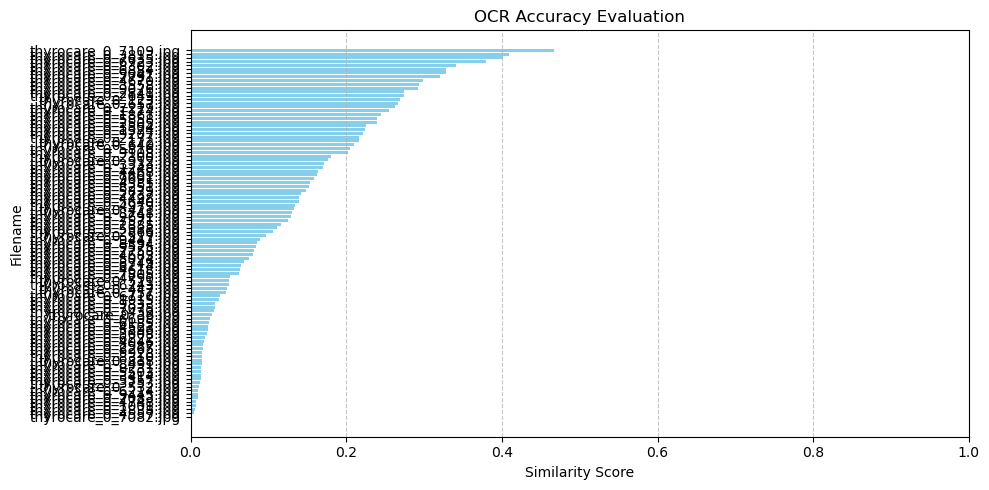

OCR Evaluation complete! Results saved with improved preprocessing, normalization, and validation checks.


In [17]:
if similarity_scores:
    sorted_indices = sorted(range(len(similarity_scores)), key=lambda i: similarity_scores[i])
    sorted_filenames = [filenames[i] for i in sorted_indices]
    sorted_scores = [similarity_scores[i] for i in sorted_indices]
    
    plt.figure(figsize=(10, 5))
    plt.barh(sorted_filenames, sorted_scores, color='skyblue')
    plt.xlabel("Similarity Score")
    plt.ylabel("Filename")
    plt.title("OCR Accuracy Evaluation")
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("OCR Evaluation complete! Results saved with improved preprocessing, normalization, and validation checks.")

In [18]:
print("Ground Truth Data:", ground_truth_data)
print("Extracted Data:", extracted_data)


Ground Truth Data: {'thyrocare_0_1001.jpg': 'Thyrocare\n“Think Thyroid, Think Thyrocar\n\n© 022-3090 0000/ 41252525 © 3591866065 ES welinesserryracare-com @ www:thyrocare.com\n\nNAME _ASHIM SENGUPTA (S8Y/M) SAMPLE COLLECTED AT =\n\nREF. 8Y see (7824957519),KALPANA MEDICOS AND CITY\nLABBINITOLE ROAD ;HOSAT ASSAM\n\nTEST ASKED © AAROGYAM 782835,782435\n\nTEST NAME TECHNOLOGY VALUE UNITS\n\n25-OH VITAMIN D (TOTAL) CLEA 2 ng/mt\n\nReference Range\n\nDerictency 20 g/m!\nINSUFFICIENCY : 20-<30 g/m\nSUFFICIENCY = 30-100 n/m\nTORICITY = >100.na/m\n\n‘Vitamin © Tora test Is analyzed on Siemens ADVIA Centaur, standardized agsinst ID-LC/MS/HS, ax per\n‘vitamin 0 Stangardtzation Program (VOSP)\n\nached FULLY AUTOMATED cit LUM\n\nVITAMIN 8-12\n\nRaterance Range :\nNormal 211-981 po/m!\n\n35r pat\n\nnical signincance\n\n‘Vitamin 812 or cyenocobalamin, is complex cormnold edmpound fourd exclusively from animal etary\nsporees, sich ws meat, eggs and mi Ts criteal ln normal DNA synthesis, which in turn